In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [45]:
words = open('names.txt', 'r').read().splitlines()
# train_words = words[:25000]     WORDS CUT INTO 80/10/10
# dev_words = words[25001: 28000]
# test_words = words[28001: 32033]


In [46]:
chars = sorted(list(set(''.join(words))))
i2s = {p+1:l for p, l in enumerate(chars)}
i2s[0] = '.'

s2i = {}

for i, l in i2s.items():
    s2i[l] = i

# s2i = {s:i for i, s in i2s.items()} same thing one line

    


In [47]:
block_size = 3
X, Y = [], [] # X is input, Y is labels
for w in words[:2]:
    
    context = [0] * block_size
    for ch in w + '.':
        print(w)
        ix = s2i[ch]
        X.append(context) # current running context
        Y.append(ix)
        print(''.join(i2s[i] for i in context), '--->', i2s[ix])
        context = context[1:] + [ix] # move it up one 
        
X = torch.tensor(X) # [n, 3] 3 leading characters of however many inputs
Y = torch.tensor(Y)  # [n] this is the next letter after the 3, and what we are trying to predict 

emma
... ---> e
emma
..e ---> m
emma
.em ---> m
emma
emm ---> a
emma
mma ---> .
olivia
... ---> o
olivia
..o ---> l
olivia
.ol ---> i
olivia
oli ---> v
olivia
liv ---> i
olivia
ivi ---> a
olivia
via ---> .


In [48]:
g2 = torch.Generator().manual_seed(214748364)

C = torch.randn((27, 2), generator=g2) # 27 x 2
V = F.one_hot(torch.tensor(5), num_classes=27).float() # 27 x 1
A = V @ C
emb = C[X]
emb.shape   # 3 arrays of [32, 2]

torch.Size([12, 3, 2])

In [72]:
# PyTorch Indexing

print(X.shape)
print(C[X].shape)
print(C[X][13,2])
print(C[1])

torch.Size([32, 3])
torch.Size([32, 3, 2])
tensor([-0.7303,  1.1832])
tensor([-0.7303,  1.1832])


In [73]:
# Creating first hidden layer of neurons

W1 = torch.randn((6, 100), generator=g2)
b1 = torch.randn(100, generator=g2)

# we want to do eeb @ W1 + b1 but because of dimensions wont work

In [74]:
# Concatenate all the pieces of embedded matrix, which is the weights at each place of letter in matrix X
# N = torch.cat((emb[:, 0, :], emb[:, 1], emb[:, 2]), 1)
# N.shape     These lines do the same thing, but below is more flexible at 

Z = torch.cat(torch.unbind(emb, 1), 1)
Z.shape

torch.Size([32, 6])

In [75]:
Z = torch.cat(torch.unbind(emb, 1), 1) # uneffiecent and creates lots of memory
Z.shape

# Q = torch.unbind(emb, 1)  this breaks the [32, 3, 2] matrix into a tuple of 3 [32, 2] arrays
# Q[0].shape 

torch.Size([32, 6])

In [10]:
## practice with a.view

a = torch.arange(18)
print(a.shape)
a.view(3,3,2) # must multiply to same numbers

torch.Size([18])


tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # this is creating a 
h

tensor([[-0.7437,  0.9111,  0.4172,  ..., -0.8906,  0.0780, -0.1556],
        [-0.9579,  0.9981,  0.9558,  ..., -0.7515,  0.7401,  0.9818],
        [ 0.5338,  0.9274,  0.1247,  ...,  0.9116,  0.4257,  0.8823],
        ...,
        [-0.9653,  0.9928,  0.9868,  ...,  0.8227, -0.8342,  0.9816],
        [-0.4200,  0.9607,  0.2070,  ...,  0.8971,  0.9916,  0.2514],
        [-0.9407,  0.9780, -0.9071,  ...,  0.9787, -0.9759, -0.2924]])

In [49]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w:
            ix = s2i[ch] 
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(.8*len(words))
n2 = int(.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # train_words
Xdev, Ydev = build_dataset(words[n1:n2]) # dev_words
Xte, Yte = build_dataset(words[n2:]) # test_words



In [8]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre


In [50]:
g2 = torch.Generator().manual_seed(214748364)

C = torch.randn((27, 10), generator=g2) # 27 x n_embeddings this is a 2d vector of all the next possible characters

W1 = torch.randn((30, 200), generator=g2) # weights (block_size(3) x n_embeddings (10))  x N_neurons
b1 = torch.randn(200, generator=g2)

W2 = torch.randn((200,27), generator=g2) # creating second hidden layer which will take in the 100 transformed matrix and connect it to 27 output neurons
b2 = torch.randn(27 , generator = g2) # bias 


params = [C, W1, W2, b1, b2]
num_params = sum(p.nelement() for p in params)
print(num_params)

11897


In [51]:
lri = []
lossi = []

tensor(2.2908, grad_fn=<NllLossBackward0>)


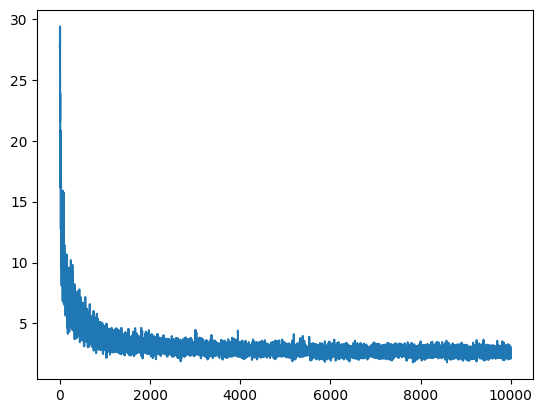

In [52]:
iters = 10000

for p in params:
    p.requires_grad = True

for i in range(iters):
    # Mini Sample
    ix = torch.randint(0, Xtr.shape[0], (32,)) # this is a sample from 0 to size of X

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # logits which are outputs
    loss = F.cross_entropy(logits, Ytr[ix])
    # counts = logits.exp()  OLD WAY TO CALCULATE LOSS ==> F.cross_entropy is better
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean() # this plucks the spot of probabilities following each Y
    # print(loss)
    # prob[0].sum()  == 1 #(normalized)

    # backward pass
    for p in params:
        p.grad = None

    # BACK PROPOGATE
    loss.backward()
    
    
    lr = .1 # using minimum found on the graph
    for p in params:
        p.data += -lr * p.grad
        
    # track stats
    lossi.append(loss.item())
    final = loss

x_plot = torch.arange(iters)
plt.plot(x_plot, lossi)
print(final)

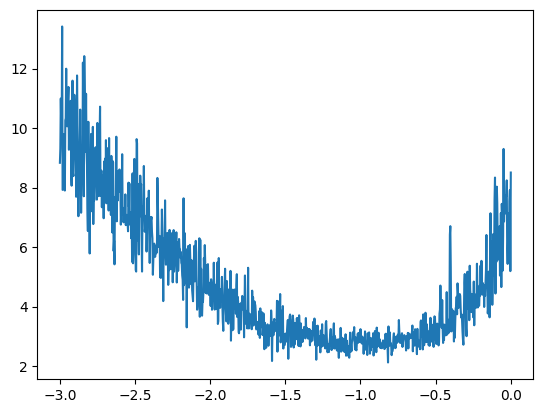

In [62]:
plt.plot(lri, lossi)

In [40]:
emb = C[Xdev]  # the network has not been trained on these, yet still performs decent
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5963, grad_fn=<NllLossBackward0>)

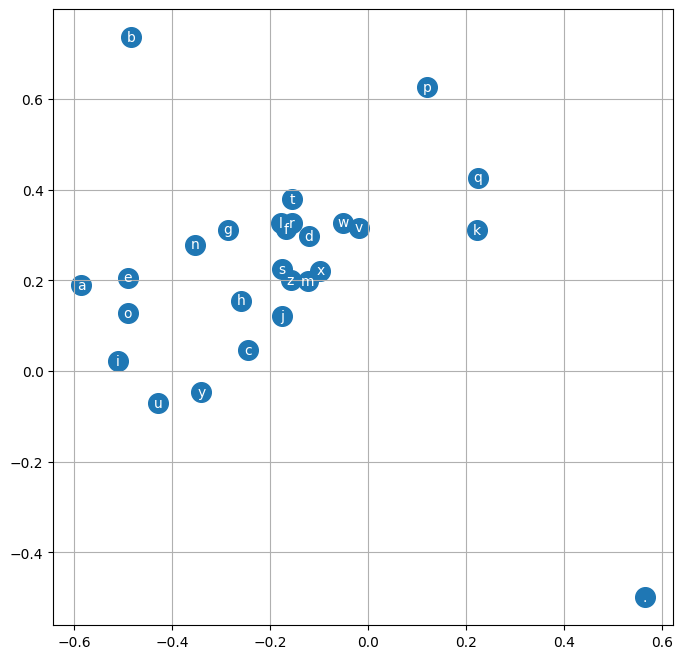

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), i2s[i], ha="center", va="center", color="white")
plt.grid('minor')

NameError: name 'blocksize' is not defined

In [62]:
blocksize = 3
for _ in range(10):
    out = []
    context = [0] * blocksize
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g2).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

print(''.join(i2s[i] for i in out))

KeyboardInterrupt: 